# 1.0 Projected revenue per client

In [28]:
# import dependencies

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

C:\Users\denis\AppData\Local\Temp\ipykernel_17012\816365406.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [29]:
df = pd.read_csv('train_V2_cleaned.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4947 entries, 0 to 4946
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   income_am              4947 non-null   float64
 1   profit_last_am         4947 non-null   float64
 2   profit_am              4947 non-null   float64
 3   damage_am              4947 non-null   float64
 4   damage_inc             4947 non-null   int64  
 5   crd_lim_rec            4947 non-null   float64
 6   credit_use_ic          4947 non-null   int64  
 7   gluten_ic              4947 non-null   int64  
 8   lactose_ic             4947 non-null   int64  
 9   insurance_ic           4947 non-null   int64  
 10  spa_ic                 4947 non-null   int64  
 11  empl_ic                4947 non-null   int64  
 12  cab_requests           4947 non-null   int64  
 13  married_cd             4947 non-null   int64  
 14  bar_no                 4947 non-null   int64  
 15  spor

## 1.1 Train/test-spit and standardisation

### 1.1.1 Shuffle data

In [30]:
from random import Random
df_shuffle = df.sample(frac=1, random_state=123)

### 1.1.2 Train/test-split

In [31]:
from sklearn.model_selection import train_test_split

X = df_shuffle.drop(['outcome_profit'],1)
y = df_shuffle['outcome_profit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

C:\Users\denis\AppData\Local\Temp\ipykernel_17012\3570332103.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df_shuffle.drop(['outcome_profit'],1)


### 1.1.3 Standardise

In [32]:
from sklearn.preprocessing import StandardScaler

num_feat = X_train.columns

scaler = StandardScaler()

scaler.fit(X_train[num_feat])

X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

X_train_stand[num_feat] = scaler.fit_transform(X_train[num_feat])
X_test_stand[num_feat] = scaler.transform(X_test[num_feat])

## 1.2 Polynomial regression

### 1.2.1 Cross-validation

In [33]:
# Calculate the best degree to use using the average score with cross-validation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

avg_scores = [None] * 3
sd_scores = [None] * 3 	  # a degree > 3 will give R^2 in the (-) thousands
for i in np.arange(0,3):
    reg_poly = Pipeline([('stand', StandardScaler()),
                  ('poly', PolynomialFeatures(degree=i)),
                  ('linear', LinearRegression(fit_intercept=False))])
    
    scores = cross_val_score(reg_poly, X_train, y_train, scoring = 'r2', cv=5)

    avg_scores[i] = scores.mean()
    sd_scores[i] = np.sqrt(scores.var())/np.sqrt(5)
    print("Order " + str(i) + ": avg R^2 = " + str(avg_scores[i]))

Order 0: avg R^2 = -0.002516610466007574
Order 1: avg R^2 = 0.2728423747687709
Order 2: avg R^2 = -1.0564246434350028e+20


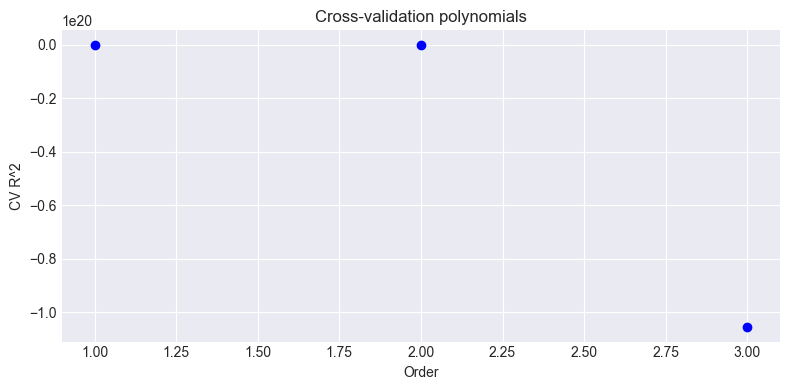

In [34]:
# Plotting the results

fig, ax = plt.subplots(figsize=(8, 4))
plt.scatter(np.arange(1,4), avg_scores, c='b', label='data')
plt.axis('tight')
plt.title("Cross-validation polynomials")
ax.set_xlabel("Order")
ax.set_ylabel("CV R^2")
plt.tight_layout()
plt.show()

In [35]:
# The best order with the maximum R^2?

max_value = max(avg_scores)
max_index = avg_scores.index(max_value)
print('The order with maximum R^2 is '+ str(max_index))

The order with maximum R^2 is 1


In [36]:
# Show the best score with the training set and testing set

reg_poly2 = Pipeline([('stand', StandardScaler()),
                  ('poly', PolynomialFeatures(degree=1)),
                  ('linear', LinearRegression(fit_intercept=False))])
reg_poly2.fit(X_train, y_train)
print(reg_poly2.score(X_train, y_train))
print(reg_poly2.score(X_test, y_test))

0.37678130487889183
0.40511949540387304


# 1.3 K-nearest Neighbors

## 1.3.1 Cross-validation

In [37]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score

K = np.arange(1,100)
cv_scores = []
sd_scores = []
# perform 5-fold cross validation on the  possible values for the radius (bandwidth)

for k in K:
    knn = KNeighborsRegressor(n_neighbors= k)
    scores = cross_val_score(knn, X_train_stand, y_train,  cv=5)
    cv_scores.append(scores.mean())
    sd_scores.append(np.sqrt(scores.var())/np.sqrt(5))

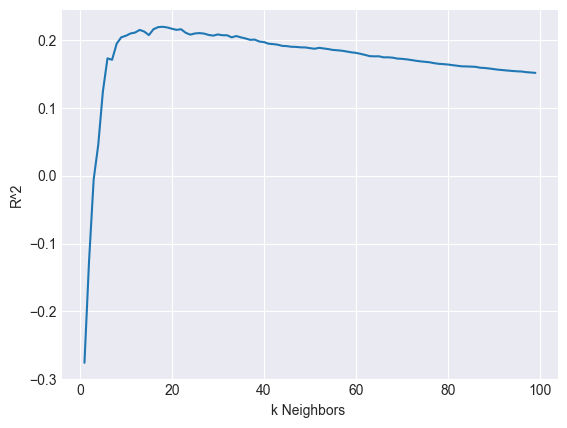

The best k is 18


In [38]:
# Plotting the results

max_value = max(cv_scores)
max_index = cv_scores.index(max_value)

plt.plot(K, cv_scores)
plt.xlabel('k Neighbors ')
plt.ylabel('R^2')

plt.show()
print('The best k is', K[max_index])

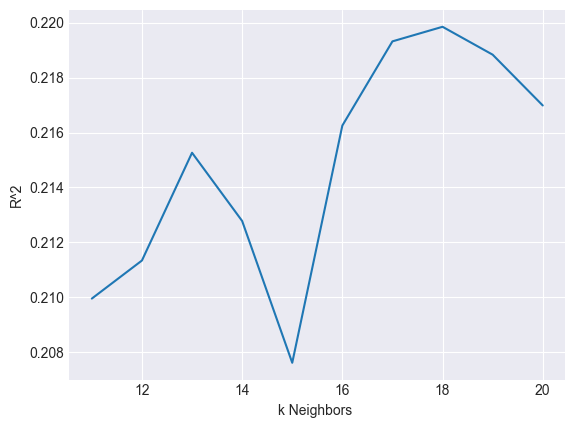

The best k is 18
The best validated score is 0.21985295708488262


In [39]:
# let's zoom in to the nearest 45-55

plt.plot(K[10:20],cv_scores[10:20])
plt.xlabel('k Neighbors ')
plt.ylabel('R^2')

plt.show()
print('The best k is', K[max_index])
print('The best validated score is', max_value)

In [42]:
knn = KNeighborsRegressor(n_neighbors=K[max_index])
knn.fit(X_train_stand, y_train)
print(f'train value for k={K[max_index]}:', knn.fit(X_train_stand, y_train))
print(f'test value for k={K[max_index]}:', knn.score(X_test_stand, y_test))

train value for k=18: KNeighborsRegressor(n_neighbors=18)
test value for k=18: 0.2855622317268305
